In [11]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
from scipy.io import wavfile
import socket
import scipy.signal as sg
import os
import sys

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

if 'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/repos/')
    experiment_folder = os.path.join('/Users/zeke//bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

#setup the data folder
ss_data_folder = os.path.join(experiment_folder, 'ss_data')
from h5tools import h5tools
from h5tools import tables
from dynamo import finch as zf

def out_2_wav(x):
    return np.array(30000*2*x/np.ptp(x)).astype(np.int16)

Computer: lookfar.local


In [ ]:
import logging
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

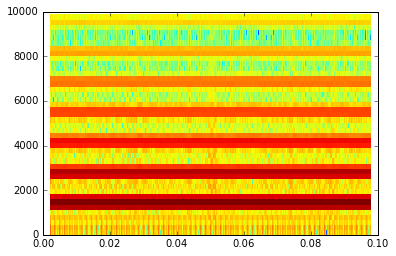

In [4]:
reload(zf)

sys_pars = {'alpha_1': 0.15,
            'beta_1': 0.15,
            'alpha_2': 0.15,
            'beta_2': 0.15,
            'gamma': 23500.,
            'Ch_inv': 4.5E10,
            'Lb_inv': 1.E-4,
            'Lg_inv': 1/82.,
            'Rb': 5E6,
            'Rh': 6E5,
            'V_ext': 0.,
            'dV_ext': 0.,
            'noise': 0.,
            'envelope': 0.,
            'noise_fraction_beta_1': 0.1,
            'noise_fraction_env': 0.1,
            's_f': 44100.,
            'steps_per_sample': 20
            }

vocal_pars = {'sys': sys_pars,
              'S_1': 0.2,
              'S_2': 0.2,
              'S_3': 0.2,
              'l_1': 1.5,
              'l_2': 1.5,
              'l_3': 1.0,
              'r_out': 0.1,
              'r_12': None,
              'r_21': None,
              'r_23': None,
              'r_32': None,
              't_12': None,
              't_21': None,
              't_23': None,
              't_32': None,
              't_in': 0.5,
              'tau_1': None,
              'tau_2': None,
              'tau_3': None,
              'max_tau': None,
              'A_1': 0.,
              'A_2': None,
              'A_3': None}

x = np.array([5.E-12,
              1.E-11,
              1.E-12,
              1.E-11,
              1.E-12
              ])

# make a test run of a segment
segment_samples = 4410 # 100ms
s_f = 44100.

t=np.arange(segment_samples)/s_f;

alpha_values = -0.15 * np.ones(segment_samples)
beta_values = -.05 * np.ones(segment_samples)
env_values = 0.05 * np.ones(segment_samples)

par_stream = np.array([alpha_values, beta_values, env_values]).T

song_synth = zf.finch(vocal_pars, par_stream, s_f=s_f, x_0=x)
#plt.plot(t, song_synth)

n_window = 192
n_overlap = 191
sigma = 0.001 * s_f
f_cut = 10000


pattern_spectrogram = spectrogram(song_synth[:,1], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(pattern_spectrogram[1], 
               pattern_spectrogram[0][pattern_spectrogram[0] < f_cut], 
               np.log(pattern_spectrogram[2][pattern_spectrogram[0] < f_cut, :]))

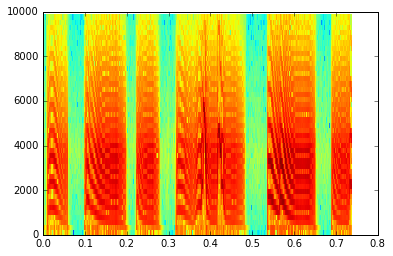

In [203]:
# go a bit further, grab actual fitted parameters and make the synth
reload(zf)
pars_file_path = os.path.abspath('/Users/zeke/repos/synthesis/synth_extern_bos.dat')
env_file_path = os.path.abspath('/Users/zeke/repos/synthesis/env_bos.dat')
song_file_path = os.path.abspath('/Users/zeke/repos/synthesis/synth_finch_py_bos.wav')

fitted_pars = np.loadtxt(pars_file_path, usecols=(2, 1))
env = np.loadtxt(env_file_path, usecols=(2,))

n_samples = min(fitted_pars.shape[0], env.shape[0])

pars_stream = np.hstack([fitted_pars[:n_samples,:], env[:n_samples].reshape(n_samples,1)])

song_synth = zf.finch(vocal_pars, pars_stream, s_f=s_f)

pattern_spectrogram = spectrogram(song_synth[:,0], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(pattern_spectrogram[1], 
               pattern_spectrogram[0][pattern_spectrogram[0] < f_cut], 
               np.log(pattern_spectrogram[2][pattern_spectrogram[0] < f_cut, :]))

wavfile.write(song_file_path, s_f, out_2_wav(song_synth[:,0]).flatten())

In [191]:
song_file_path = os.path.abspath('/Users/zeke/repos/synthesis/finch_py_sinty.wav')
wavfile.write(song_file_path, s_f, out_2_wav(song_synth[:,0]).flatten())

In [206]:
vocal_pars

{'A_1': 0.82433662105578154,
 'A_2': None,
 'A_3': None,
 'S_1': 0.2,
 'S_2': 0.2,
 'S_3': 0.2,
 'l_1': 1.5,
 'l_2': 1.5,
 'l_3': 1.0,
 'max_tau': 37,
 'r_12': 0.0,
 'r_21': 0.0,
 'r_23': 0.0,
 'r_32': 0.0,
 'r_out': 0.1,
 'sys': {'Ch_inv': 45000000000.0,
  'Lb_inv': 0.0001,
  'Lg_inv': 0.012195121951219513,
  'Rb': 5000000.0,
  'Rh': 600000.0,
  'V_ext': 2580.9785689404844,
  'alpha_1': 0.14999999999999999,
  'alpha_2': 0.15,
  'beta_1': 0.14722863434376532,
  'beta_2': 0.15,
  'dV_ext': -345318687.84703594,
  'envelope': 0.484259,
  'gamma': 23500.0,
  'noise': array([ 1.84583675, -0.18475771]),
  'noise_fraction_beta_1': 0.1,
  'noise_fraction_env': 0.1},
 't_12': 1.0,
 't_21': 1.0,
 't_23': 1.0,
 't_32': 1.0,
 't_in': 0.5,
 'tau_1': 37,
 'tau_2': 37,
 'tau_3': 25}

In [20]:
h5_path = os.path.join('/Users/zeke/repos/synthesis/h5test2.h5')

import h5py

with h5py.File(h5_path, 'w') as f:
    sweep_group = f.create_group('sweep_000')
    h5tools.dict_2_group(sweep_group, vocal_pars, 'vocal_pars')

with h5py.File(h5_path, 'r') as f: 
    sweep_dict = dict()
    read_dict2 = h5tools.group_2_dict(sweep_dict, f['/sweep_000'], 'sweep_000')


DEBUG:h5tools:Translating dictionary key vocal_pars into its own group
2016-10-06 18:33:06,012 h5tools      DEBUG    Translating dictionary key vocal_pars into its own group
DEBUG:h5tools:Translating dictionary key sys into its own group
2016-10-06 18:33:06,015 h5tools      DEBUG    Translating dictionary key sys into its own group
DEBUG:h5tools:Translating group sweep_000 into its own dictionary
2016-10-06 18:33:06,020 h5tools      DEBUG    Translating group sweep_000 into its own dictionary
DEBUG:h5tools:Translating group vocal_pars into its own dictionary
2016-10-06 18:33:06,021 h5tools      DEBUG    Translating group vocal_pars into its own dictionary
DEBUG:h5tools:Translating group sys into its own dictionary
2016-10-06 18:33:06,023 h5tools      DEBUG    Translating group sys into its own dictionary


In [10]:
with h5py.File(h5_path, 'r') as f:
    print f['sweep_000']['vocal_pars'].name

/sweep_000/vocal_pars


In [17]:
ab_array = np.array([[-0.15, -0.15], [-.15, -.16]])
ab_array

array([[-0.15, -0.15],
       [-0.15, -0.16]])

In [91]:
log_path = os.path.join('/Users/zeke/repos/synthesis/h5test2.h5')
hdlr = logging.FileHandler('/Users/zeke/repos/synthesis/h5test2.log')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)

In [94]:
reload(h5tools)
sweep_name = 'sweep_000'
gamma = 23600
sim_pars = {'sweep_name' : 'sweep_000',
           'gamma': 23610,
           'alpha': -0.15,
           'beta': -0.17,
           'vocal_pars': vocal_pars,
           'sim_samples': 4410,
            's_f': 44100.,
            'steps_per_sample': 20,
           'x': np.array([5.E-12, 1.E-11, 1.E-12, 1.E-11, 1.E-12])
           }

def store_sim(sim_pars, h5_file):
    sweep_group = h5_file.require_group(sim_pars['sweep_name'])
    h5tools.dict_2_group(sweep_group, sim_pars['vocal_pars'], 'vocal_pars')
    synth_group = sweep_group.require_group('synth')
    # create the group for the gamma
    gamma_group = synth_group.require_group('{0:5d}'.format(sim_pars['gamma']))
    sweep_table = tables.unlimited_rows_data(gamma_group, 'alpha_beta', 
                                             np.array([sim_pars['alpha'], 
                                                       sim_pars['beta']]).reshape([1,2]))
                                            
    
    alpha_values = sim_pars['alpha'] * np.ones(sim_pars['sim_samples'])
    beta_values = sim_pars['beta'] * np.ones(sim_pars['sim_samples'])
    env_values = np.ones(sim_pars['sim_samples'])
    par_stream = np.array([alpha_values, beta_values, env_values]).T
    for key in ['alpha', 'beta', 'gamma', 's_f', 'steps_per_sample']:
        vocal_pars['sys'][key] = sim_pars[key]
    song_synth = zf.finch(vocal_pars, par_stream, x_0=x)
    pin_table = tables.unlimited_rows_data(gamma_group, 'pre_in', 
                                           song_synth[:,1].reshape([1,-1]))
    pout_table = tables.unlimited_rows_data(gamma_group, 'pre_out', 
                                            song_synth[:,0].reshape([1,-1]))

try:
    with h5py.File(h5_path, 'w') as f:
        store_sim(sim_pars, f)
        store_sim(sim_pars, f)
        logger.info('done')
except UnboundLocalError, err:
    last_err = err
    print err

DEBUG:h5tools:Translating dictionary key vocal_pars into its own group
2016-10-06 21:13:49,332 h5tools      DEBUG    Translating dictionary key vocal_pars into its own group
DEBUG:h5tools:Translating dictionary key sys into its own group
2016-10-06 21:13:49,334 h5tools      DEBUG    Translating dictionary key sys into its own group
INFO:tables:Creating unbounded table /sweep_000/synth/23610 in group alpha_beta
2016-10-06 21:13:49,338 tables       INFO     Creating unbounded table /sweep_000/synth/23610 in group alpha_beta
INFO:tables:Creating unbounded table /sweep_000/synth/23610 in group pre_in
2016-10-06 21:13:53,998 tables       INFO     Creating unbounded table /sweep_000/synth/23610 in group pre_in
INFO:tables:Creating unbounded table /sweep_000/synth/23610 in group pre_out
2016-10-06 21:13:54,000 tables       INFO     Creating unbounded table /sweep_000/synth/23610 in group pre_out
DEBUG:h5tools:Translating dictionary key vocal_pars into its own group
2016-10-06 21:13:54,001 h5t